In [1]:
%matplotlib inline

In [79]:
import numpy as np
from io import StringIO
from astropy.constants import c
import matplotlib.pyplot as plt
import itertools
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
from io import BytesIO
import base64

In [3]:
c_const = c.value
frequency  = 93.7e9
wavelength = c_const/frequency

In [4]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": "pdflatex",  # default is xetex
    }
)

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize

In [5]:
def calc_R(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [6]:
def _altaz_to_earthlocation(altaz):
    local_itrs = altaz.transform_to(ITRS(location=altaz.location))
    itrs = ITRS(local_itrs.cartesian + altaz.location.get_itrs().cartesian)
    return itrs.earth_location

In [7]:
def _earthlocation_to_altaz(location, reference_location):
    # See
    # https://docs.astropy.org/en/stable/coordinates/common_errors.html#altaz-calculations-for-earth-based-objects
    # for why this is necessary and we cannot just do
    # `get_itrs().transform_to(AltAz())`
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [8]:
def local_to_earth_location(x, y, z, reference_location):
    cart = CartesianRepresentation(x, y, z)
    altaz = AltAz(cart, location=reference_location)
    return _altaz_to_earthlocation(altaz)

In [76]:
def earth_location_to_local_enu(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    ned_coords =  altaz.cartesian.xyz
    enu_coords = ned_coords[1], ned_coords[0], -ned_coords[2]
    return np.array(enu_coords)

In [10]:
def enu_to_local_altaz(enu_baselines, distance):
    elevation = np.arctan2(enu_baselines[0], enu_baselines[1])
    azimuth = np.arcsin(enu_baselines[2]/distance)
    return elevation, azimuth

In [60]:
def b_enu_to_b_equatorial(b_enu, lat_obs):
    """
    b_enu: coordenadas de los baselines en el sistema de referencia plano tangente local (ENU)
    lat_obs: latitud del centro del observatorio, expresado en radianes
    """
    abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
    
    azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

    x_equatorial = np.cos(lat_obs) * np.sin(elevation) - np.sin(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    y_equatorial = np.cos(elevation) * np.sin(azimuth)
    z_equatorial = np.sin(lat_obs) * np.sin(elevation) + np.cos(lat_obs) * np.cos(elevation) * np.cos(azimuth)
    baseline_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])
    return baseline_equatorial

In [55]:
def baselines_enu(enu_coords):
    """
    enu_coords: coordenadas de las antenas en el sistema de referencia plano tangente local (ENU)
    """
    b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
    b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]
    return b_enu

In [64]:
def compute_HA(hObs, dec, t_sampling):
    HA = np.arange(-hObs, hObs, (t_sampling/60)) * np.pi / 12.
    dec = np.radians(dec)
    return HA, dec

In [46]:
def coverage(baselines, HA, dec):
    """
    baselines: arreglo de coordenadas de los baselines en el sistema ecuatorial
    
    """
    R_matrix = calc_R(HA, dec)
    uvw_meters = np.sum(R_matrix[...,np.newaxis]*baselines[np.newaxis,:,np.newaxis,:], axis=1)
    UV_coverage = np.column_stack((uvw_meters[0].reshape(-1), uvw_meters[1].reshape(-1)))
    return UV_coverage

In [49]:
antenna_config_path = r"C:\Users\matia\Desktop\B\casa-6.5.5-21-py3.8\lib\py\lib\python3.8\site-packages\casadata\__data__\alma\simmos"
dtype=[('x','f4'),('y','f4'),('z','f4'),('D','f4'),('id','S5')]

# Caso coordenadas no están en ENU

In [50]:
antenna_config_file = antenna_config_path + "\\vla.d.cfg"
data = np.loadtxt(antenna_config_file, dtype=dtype)

In [51]:
local_xyz = EarthLocation.from_geocentric(data["x"], data["y"], data["z"], u.m)

In [72]:
telescope_center = EarthLocation.of_site("vla")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [77]:
enu_coords = earth_location_to_local_enu(local_xyz, telescope_center)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

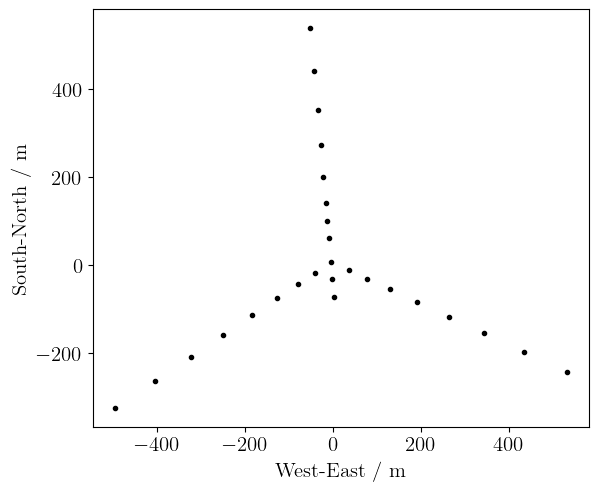

In [78]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [56]:
baseline_enu = baselines_enu(enu_coords)

In [61]:
baseline_equatorial = b_enu_to_b_equatorial(baseline_enu, latitude)

In [65]:
HA, dec = compute_HA(1, 90, 6)

In [66]:
cover = coverage(baseline_equatorial, HA, dec)

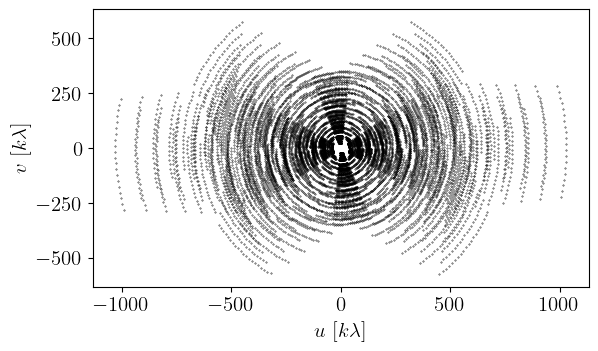

In [80]:
fig, ax = plt.subplots()
ax.scatter(cover[:,0],cover[:,1], c="black", marker=".", s=0.4)
ax.set_xlabel(r'$u\ [k\lambda]$') 
ax.set_ylabel(r'$v\ [k\lambda]$')
ax.set_aspect('equal')

In [81]:
buf = BytesIO()
fig.savefig(buf, format='png')
image_base64 = base64.b64encode(buf.getvalue()).decode()

In [82]:
image_base64

'iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOy9eVxTd77//0pYEoSwKKAiKIu4oRVwh1pBC+oojLQueJ1u1tqx01+XO1bv6L0jzKM6LfY7tjPq3LY6ra1TwNrSCq0OWEQr4IK4L6hsIouRHQIJS/L7w/v5zElIQgJBpbyfj4cPNTk5OTk5Oed13svrLdJoNBoQBEEQBEEQAwbxo94AgiAIgiAI4uFCApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiAIYoBBApAgCIIgCGKAQQKQIAiCIAhigEECkCAIgiA

# Caso las coordenadas ya están en ENU

In [26]:
antenna_config_file = antenna_config_path + "\\alma.cycle1.3.cfg"
dataENU = np.loadtxt(antenna_config_file, dtype=dtype)

In [27]:
enu_coords = np.vstack([dataENU["x"], dataENU["y"], dataENU["z"]])

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

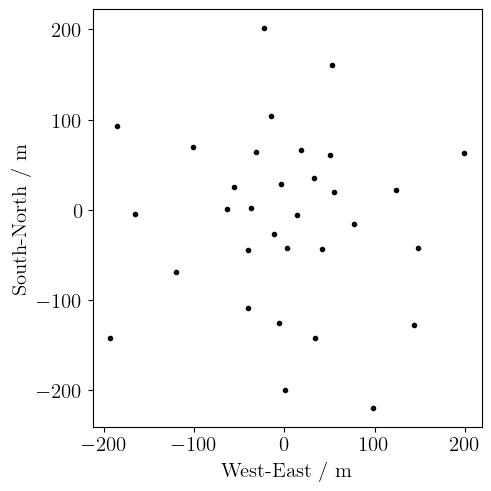

In [28]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(enu_coords[0], enu_coords[1], '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [29]:
# Calculate combinations of pairs of antennas in ENU coordinates
antenna_ids = np.arange(0, enu_coords.shape[1])
n_antennas = len(antenna_ids)
b_enu = enu_coords[..., np.newaxis] - enu_coords[:, np.newaxis,:]
b_enu = b_enu[:, ~np.eye(b_enu.shape[-1],dtype=bool)]

In [30]:
abs_b = np.sqrt(np.sum(b_enu**2, axis=0))
azimuth, elevation = enu_to_local_altaz(b_enu, abs_b)

In [31]:
telescope_center = EarthLocation.of_site("alma")
latitude = telescope_center.to_geodetic().lat.to(u.rad).value

In [32]:
x_equatorial = (np.cos(latitude) * np.sin(elevation) - np.sin(latitude) * np.cos(elevation) * np.cos(azimuth))
y_equatorial = (np.cos(elevation) * np.sin(azimuth))
z_equatorial = (np.sin(latitude) * np.sin(elevation) + np.cos(latitude) * np.cos(elevation) * np.cos(azimuth))

In [33]:
xyz_equatorial = abs_b * np.vstack([x_equatorial, y_equatorial, z_equatorial])

In [34]:
#HA = np.arange(-0.5*15.*(np.pi/180.), 0.5*15.*(np.pi/180.), 0.1*(np.pi/180.))  # [radians]
HA = np.arange(-1, 1, 0.1) * np.pi / 12.
dec = np.radians(55)

In [35]:
R_matrix = calc_R(HA, dec)
uvw_meters = np.sum(R_matrix[...,np.newaxis]*xyz_equatorial[np.newaxis,:,np.newaxis,:], axis=1)

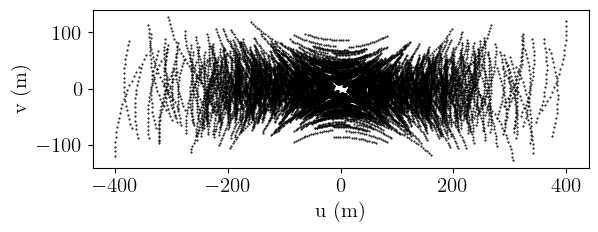

In [36]:
fig, ax = plt.subplots()
ax.scatter(uvw_meters[0],uvw_meters[1], c="black", marker=".", s=1)
ax.set_xlabel('u (m)') 
ax.set_ylabel('v (m)')
ax.set_aspect('equal')

In [37]:
""" import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """


' import matplotlib.animation\nimport matplotlib.pyplot as plt\nimport numpy as np\nplt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\n#x = np.arange(0, len(HA))\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '